In [77]:
import numpy as np
from SSMTools import kalmanSmooth, kfSetup, pcaEstMD, logL
from Utilities import nanMSE

# Note that this is outdated and the likelihood below is incorrect.

# Model 1
$y_t \sim N(C \vec{v}_t, R)$ where $\vec{x}_t$ has nLF dimensions and $\vec{x}_t \sim N(0, Q)$. This is just an SSM with $A = 0$.

In [59]:
N = 10
T = 100

u_true = np.random.multivariate_normal([0, 0, 0], np.diag([1, 2, 3]), N)
v_true = np.random.multivariate_normal([0, 0, 0], np.diag([1, 1, 1]), T)

print u_true.shape
print v_true.shape

y_true = np.dot(u_true, v_true.T)

(10, 3)
(100, 3)


In [60]:
# Remove some data
y_degraded = y_true.copy()

# Delete 80% of the observations
missing_frac = 0.8
n_to_delete = int(missing_frac * y_degraded.size)

for idx in np.random.randint(0, y_degraded.size, n_to_delete):    
    y_degraded[idx / y_degraded.shape[1], idx % y_degraded.shape[1]] = np.nan

## Run imputation methods
nLF is the dimensionality of the latent representation

In [61]:
nLF = 3

### Latent factor model

In [130]:
def lf_decomp(y, y_true, u_i, v_i, n_steps, step_size, beta_reg):
    """
    Computes latent factor decomposition using gradient descent
    
    Arguments
    -y: n x m array of data
    -u_i: n x n_LF guess for latent factor matrix
    -v_i: m x n_LF guess for latent factor matrix
    
    Returns: latent factor matrices
    """
    # Observed points that are not in the training set
    y_test = y_true.copy()
    y_test[np.where(~np.isnan(y))] = np.nan
    
    u = u_i.copy()
    v = v_i.copy()
    
    # Keep track of MSE at each step
    mses = np.zeros(n_steps + 1)
    mses[0] = nanMSE(y_true, np.dot(u, v.T))
    
    for step in xrange(n_steps):
        # Error matrix
        e = y - np.dot(u, v.T)
        # Set errors for unobserved values equal to zero so they're
        # ignored in gradient descent update step
        e[np.isnan(y)] = 0.0
        
        # Carefully update the latent factors
        u_next = u * (1.0 - step_size * beta_reg) + step_size * np.dot(e, v)
        v = v * (1.0 - step_size * beta_reg) + step_size * np.dot(e.T, u)
        u = u_next
        
        # Compute MSE
        mses[step + 1] = nanMSE(y_test, np.dot(u, v.T))
        
    return u, v, mses

Run LF algorithm. Probably could initialize more intelligently...

In [131]:
def lf_impute(y, y_true, nLF, n_steps=1000, step_size=1e-5, beta_reg=0.0):
    u_i = np.random.multivariate_normal(nLF*[0], np.diag(nLF*[1]), size=N)
    v_i = np.random.multivariate_normal(nLF*[0], np.diag(nLF*[1]), size=T)
    
    u_lf, v_lf, mses = lf_decomp(y, y_true, u_i, v_i, n_steps, step_size, beta_reg)
    
    return np.dot(u_lf, v_lf.T), mses

### State space EM

In [64]:
A = np.zeros(2*[nLF])

In [65]:
def m_step_1(y_imp, x_hat, P):
    N, T = y_imp.shape
    
    # Observation matrix
    C_new = np.dot(np.dot(y_imp, x_hat.T), np.linalg.pinv(np.sum(P, axis=0)))
    # Observation covariance
    R_new = 1.0 / float(T) * (np.dot(y_imp, y_imp.T) - np.dot(C_new, np.dot(x_hat, y_imp.T)))
    
    # State noise covariance
    Q_new = 1.0 / (T - 1.0) * np.sum(P[1:], axis=0)
    
    # Initial state mean
    pi0_new = x_hat[:, 0]
    # Initial state covariance
    sigma0_new = P[0, :, :] - np.outer(x_hat[:, 0], x_hat[:, 0].T)
    
    return C_new, R_new, Q_new, pi0_new, sigma0_new

In [133]:
def ssmem_impute(y, y_true, nLF, n_steps=100):
    # Observed points that are not in the training set
    y_test = y_true.copy()
    y_test[np.where(~np.isnan(y))] = np.nan
    
    # Keep track of MSE at each step
    mses_test = np.zeros(n_steps + 1)
    
    # Keep track of log likelihood
    log_L = np.zeros(n_steps + 1)
    
    # Randomly initialize observation matrix and hidden state
    x_hat = np.random.multivariate_normal(nLF*[0], np.diag(nLF*[1]), size=T).T
    C = np.random.multivariate_normal(nLF*[0], np.diag(nLF*[1]), size=N)
    
    # Initialize the SSM
    pi0, sigma0, A, Q, R = kfSetup(y, C, x_hat, nLF)
    
    # Run EM
    for i in range(n_steps):
        # E step (ie, run Kalman smoother)
        x_hat, sigma_s, _, y_ssm1, _ = kalmanSmooth(y, pi0, sigma0, A, C, Q, R, nLF)
        
        # Compute MSE
        mses_test[i] = nanMSE(y_test, y_ssm1)

        # Compute log(L)
        log_L[i] = np.sum(logL(x_hat, y, pi0, sigma0, A, C, Q, R))
        # Need to add contribution from covariance matrices
        log_L[i] = log_L[i] - 0.5 * T * np.log(np.linalg.det(R)) - 0.5 * (T - 1) * np.log(np.linalg.det(Q))

        # Second moment
        P = np.zeros((T, nLF, nLF))
        for t in range(T):
            P[t, :, :] = sigma_s[t, :, :] + np.outer(x_hat[:, t], x_hat[:, t].T)

        # M step
        C, R, Q, pi0, sigma0 = m_step_1(y_ssm1, x_hat, P)

    # Re-estimate hidden state one last time
    _, _, _, y_ssm1, _ = kalmanSmooth(y, pi0, sigma0, A, C, Q, R, nLF)
    
    # Compute final MSE
    mses_test[n_steps] = nanMSE(y_test, y_ssm1)
    
    # Compute final log(L)
    log_L[n_steps] = np.sum(logL(x_hat, y, pi0, sigma0, A, C, Q, R))
    
    return y_ssm1, mses_test, log_L

## Compute MSEs
Also test dynamic factor model PCA estimator

In [67]:
y_pca, C, x_hat_pca = pcaEstMD(y_degraded, nLF, 1000)

In [68]:
y_lf, mses_lf = lf_impute(y_degraded, y_true, nLF, n_steps=100000)

In [134]:
y_ssm1, mses_test_ssm1, logL_ssm1 = ssmem_impute(y_degraded, y_true, nLF, n_steps=100)

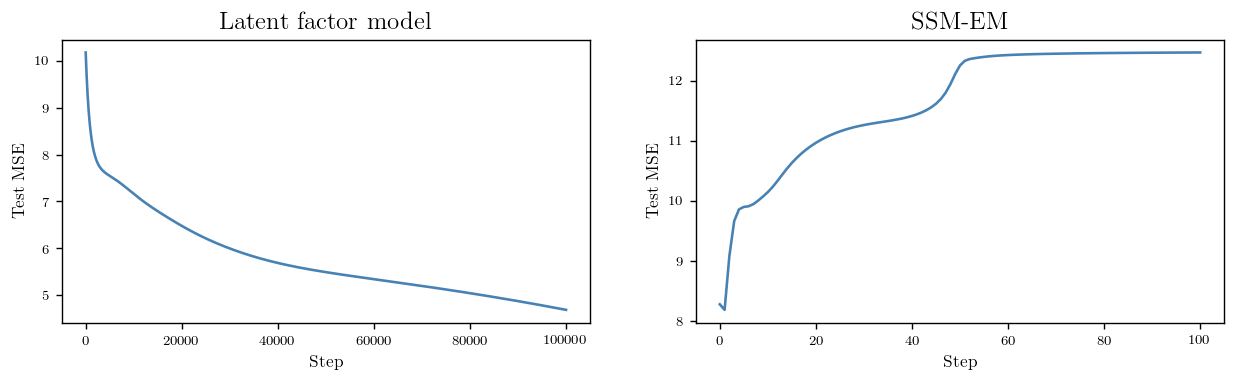

In [140]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(mses_lf)
plt.title("Latent factor model")
plt.xlabel("Step")
plt.ylabel("Test MSE")

plt.subplot(1, 2, 2)
plt.plot(mses_test_ssm1, label="Test")
plt.title("SSM-EM")
plt.xlabel("Step")
plt.ylabel("Test MSE")

# plt.subplot(1, 3, 3)
# plt.plot(logL_ssm1) 
# plt.title("SSM-EM")
# plt.xlabel("Step")
# plt.ylabel("log(L)")

In [39]:
print "%f missing data\n" % (missing_frac * 100)
print "Latent factor model: %f" % nanMSE(y, y_lf)
print "SSM-EM: %f" % nanMSE(y, y_ssm1)
print "PCA: %f" % nanMSE(y, y_pca)

80.000000 missing data

Latent factor model: 0.618281
SSM-EM: 2.860794
PCA: 0.197068
